In [0]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [0]:
class LogisticRegressionGD(object):
  """Logistic Regression Classifier using gradient descent.

  Parameters
  ------------
  eta : float
    Learning rate (between 0.0 and 1.0)
  n_iter : int
    Passes over the training dataset.
  random_state : int
    Random number generator seed for random weight initialization.
  
  Attributes
  -----------
  w_ : 1d-array
    Weights after fitting.
  cost_ : list
    Logistic cost function value in each epoch.
  """
  def __init__(self, eta=0.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    """ Fit training data.

    Parameters
    ----------
    X : {array-like}, shape = [n_examples, n_features]
      Training vectors, where n_examples is the number of examples and 
      n_features is the number of features.
    y : array-like, shape = [n_examples]
      Target values.
    
    Returns
    -------
    self : object
    """
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01,
                          size=1 + X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
      net_input = self.net_input(X)
      output = self.activation(net_input)
      errors = (y - output)
      self.w_[1:] += self.eta * X.T.dot(errors)
      self.w_[0] += self.eta * errors.sum()

      # note that we compute the logistic 'cost' now
      # instead of the sum of squared errors cost
      z=net_input
      #cost = -y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output))
      cost = (y.dot(np.log(1. + np.exp(-z))) + 
             (1 - y).dot(z+np.log(1. + np.exp(-z))))
      self.cost_.append(cost)
    return self

  def net_input(self, X):
    """Calculate net input"""
    return np.dot(X, self.w_[1:]) + self.w_[0]
      
  def activation(self, z):
    """Compute logistic sigmoid activation"""
    #return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    return 1. / (1. + np.exp(-z))
      
  def predict(self, X):
    """Return class label after unit step"""
    return np.where(self.net_input(X) >= 0.0, 1, 0)

In [573]:
# We are interested in how variables, such as GRE (Graduate Record Exam scores), 
# GPA (grade point average) and prestige of the undergraduate institution, 
# affect admission into graduate school. 
#
# The response variable, admit/don’t admit, is a binary variable.
# There are three predictor variables: gre, gpa and rank. 
# We will treat the variables gre and gpa as continuous. 
# The variable rank takes on the values 1 through 4. Institutions with a rank 
# of 1 have the highest prestige, while those with a rank of 4 have the lowest.
data = pd.read_csv('https://stats.idre.ucla.edu/stat/data/binary.csv')
#data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
#                   header=None, 
#                   encoding='utf-8')

data.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


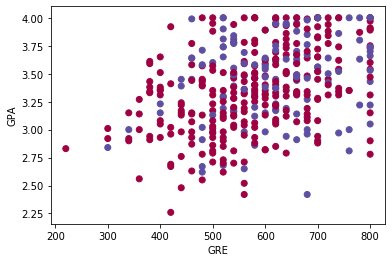

In [574]:
# "admit" is the column with the label (0 or 1).
y=data.iloc[:,0].values
#y=data.iloc[0:100,4].values
#y = np.where(y == 'Iris-setosa', 0, 1)
#print(y)

# The rest of the columns are the features.
X = data.iloc[:,1:3].values
#X = data.iloc[0:100,[0,2]].values
#rint(X)

# Visualize the training examples. Since we have 3 features, we actually 
# project onto two features in each plot (GRE vs GPA, and then GRE vs rank).
#xcoords, ycoords, zcoords = zip(*X)
xcoords, ycoords = zip(*X)

#plt.subplot(1, 2, 1)
plt.scatter(xcoords, ycoords, c=y, cmap="Spectral")
plt.xlabel('GRE')
plt.ylabel('GPA')

#plt.subplot(1, 2, 2)
#plt.scatter(xcoords, zcoords, c=y, cmap="Spectral")
#plt.xlabel('GRE')
#plt.ylabel('rank')
plt.show()


The preceding scatterplot shows the distribution of admissions (blue = admit / red = not admit) in the 
dataset along the two feature axes: GRE and GPA (or GRE and university rank). In this two-dimensional feature subspace, we can see that a linear decision boundary is NOT sufficient to separate admission from non-admission.
Thus, a linear classifier such as logistic regression should not be able to classify the examples in this dataset perfectly.

We will see that this is indeed the case: the logistic cost function does not tend to zero, and the linear decision boundary does not separate red/blue points successfully.

In [0]:
# We use the scikit-learn function 
#   train_test_split(X, y, test_size=0.33, random_state=42) to split the data 
# into training and test data sets, given 33% of the records to the test 
# data set. The training data set is used to train the mode, meaning find 
# the weights and biases. The test data set is used to check its accuracy.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Normalize the data values, by substracting the sample mean and dividing 
# by standard deviation. 
# THIS STEP IS VERY IMPORTANT! Without normalization, gradient descent needs 
# to take much smaller steps.
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

Now, it's time to train our logistic regression algorithm on the data subset that we
just extracted. Also, we will plot the misclassification error for each epoch to check
whether the algorithm converged and found a decision boundary that separates the
two classes

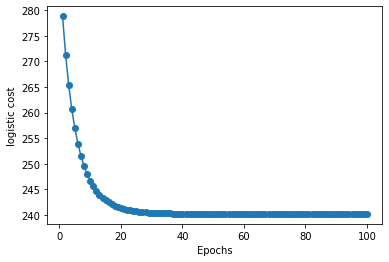

Weights after fitting:  [-0.80945479  0.31022635  0.28683277]


In [576]:
lrgd = LogisticRegressionGD(n_iter=100, eta=0.001).fit(X_std, y)

# Let's now plot the cost against the number of epochs
plt.plot(range(1, len(lrgd.cost_) + 1),
         lrgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('logistic cost')
plt.show()

print("Weights after fitting: ",lrgd.w_)
#print(lrgd.cost_)

# Interpretation of the weights after fitting
The logistic regression coefficients give the change in the log odds of the outcome for a one unit increase in the predictor variable.

Note that while logistic regression produces it, the odds ratio for the intercept (first coefficient) is not generally interpreted.

For every one (normalized) unit change in GRE, the log odds of admission (versus non-admission) increases by 0.31022635

For every one (normalized) unit change in GPA, the log odds of admission (versus non-admission) increases by 0.28683277

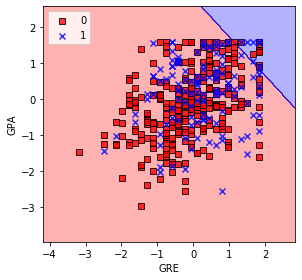

In [577]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
  # setup marker generator and color map
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # plot the decision surface
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  Z = Z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  # plot class examples
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0],
                y=X[y == cl, 1],
                alpha=0.8,
                c=colors[idx],
                marker=markers[idx],
                label=cl,
                edgecolor='black')
    
plot_decision_regions(X_std, y, classifier=lrgd)
plt.xlabel('GRE')
plt.ylabel('GPA')
plt.legend(loc='upper left')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()